In [1]:
import csv
import gensim
import keras
import matplotlib.pyplot as plt
#plt.style.use('dark_background')
import numpy as np
import os
import pandas as pd

from key_words_extract import selectCat
from gensim.models import Word2Vec
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import sequence, text
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Using TensorFlow backend.


In [ ]:
RANDOM_SEED = 42
NB_CATEGORIES = 51
CORRECTION = False

PADDING = 100
PRE_TRAINED_DIM = 300
REDUCED_DIM = 100

TRAINABLE = True # Training the embedding can lead to overfitting

dataDirPath = './challenge_data'
embeddingsDirPath = './../word_embeddings/'
xPath = os.path.join(dataDirPath, 'input_train.csv')
yPath = os.path.join(dataDirPath, 'output_train.csv')
xTestPath = os.path.join(dataDirPath, 'input_test.csv')
embeddingPath = os.path.join(embeddingsDirPath, 'wiki.fr.vec')
#embeddingPath = os.path.join(embeddingsDirPath, 'retrained_fr.vec')
# embeddingPath = os.path.join(embeddingsDirPath, 'retrained_questions.vec')

In [ ]:
pretrainedEmbeddings = gensim.models.KeyedVectors.\
    load_word2vec_format(embeddingPath, binary=False)

In [ ]:
x = pd.read_csv(xPath, delimiter=';', usecols=[1]).values.ravel()
xTest = pd.read_csv(xTestPath, delimiter=';', usecols=[1]).values.ravel()
y = pd.read_csv(yPath, delimiter=';', usecols=[1]).values.ravel()

In [ ]:
correctionsDict = {}
correctionsPath = os.path.join(dataDirPath, 'corrections.csv')

with open(correctionsPath, 'r') as f:
    for key, val in csv.reader(f):
        correctionsDict[key] = val

def spellingCorrection(sentence, correctionsDict={}, verbose=False):
    correctedSentence = []
    nb_corrections = 0
    for word in sentence.split():
        if word in correctionsDict.keys():
            word = correctionsDict[word]
            nb_corrections += 1
        correctedSentence.append(word)
    if verbose:
        return ' '.join(correctedSentence), nb_corrections
    else:
        return ' '.join(correctedSentence)

nb_corr = 0
if CORRECTION:
    for i, s in enumerate(x):
        cor = spellingCorrection(s, correctionsDict, verbose = True)
        x[i] = cor[0]
        nb_corr += cor[1]

    for i, s in enumerate(xTest):
        cor = spellingCorrection(s, correctionsDict, verbose = True)
        xTest[i] = cor[0]
        nb_corr += cor[1]
print(nb_corr)

In [ ]:
tokenizer = text.Tokenizer(
    num_words=1e5,
    filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'´’™©®«»",
    split=" "
)

tokenizer.fit_on_texts(np.concatenate((x, xTest)))
vocabulary = tokenizer.word_index.keys()
print('Vocabulary size: ', len(vocabulary))

In [ ]:
x = tokenizer.texts_to_sequences(x)
x = sequence.pad_sequences(x, PADDING)
xTest = tokenizer.texts_to_sequences(xTest)
xTest = sequence.pad_sequences(xTest, PADDING)

y = to_categorical(y, num_classes=NB_CATEGORIES)

In [ ]:
xTrain, xValid, yTrain, yValid = train_test_split(x, y, test_size=.2,
                                                  random_state=RANDOM_SEED)

In [ ]:
MEDICAMENTS = []

with open(os.path.join(dataDirPath, 'medicList.txt')) as f:
    for line in f:
        MEDICAMENTS.append(line.lower().rstrip())

print('Liste de médicaments regroupant les libéllés ATC et les'
      'dénominations de spécialité, de taille: {}'.format(len(MEDICAMENTS)))
print('Sample of medicament names: ', MEDICAMENTS[:10])

In [ ]:
from unidecode import unidecode

In [ ]:
embeddings = np.zeros((len(vocabulary) + 1 , PRE_TRAINED_DIM))
not_in_pretrained = []
detected_medic = []

for word, idx in tokenizer.word_index.items():
    if word not in pretrainedEmbeddings.vocab:
        unaccented = unidecode(word)
        if word in MEDICAMENTS:
            vec = pretrainedEmbeddings['médicament']
            detected_medic.append(word)
        else:
            vec = np.zeros(PRE_TRAINED_DIM)
            not_in_pretrained.append(word)
    else:
        vec = pretrainedEmbeddings[word]

    # word_to_index is 1-based! the 0-th row, used for padding, stays at zero
    embeddings[idx,] = vec

In [ ]:
print('---------- Embedding Created ----------')
print('Number of words in corpus that do not appear in '
      'pretrained Fasttext: ', len(not_in_pretrained))
print('size of the embedding: {}'.format(embeddings.shape))

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=REDUCED_DIM)
reducedEmbeddings = pca.fit_transform(embeddings)

In [ ]:
class CustomModel():
    '''Generic workflow class.'''

    def __init__(self, **kwargs):
        self.verbose = kwargs.get('verbose', False)

        self.nbCategories = kwargs['nbCategories']
        self.paddingLength = PADDING
        self.trainable = kwargs.get('trainable', False)

    def train(self, x, y, epochs= 10, batch_size=32, validation_data=None, callback=False):
        if callback == True:
            filepath= '../models_checkpoints/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
            checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                                         verbose=1, save_best_only=True, mode='max')
            callbacks_list = [checkpoint]

            return self.model.fit(x, y, shuffle='batch', epochs=epochs,
                                  verbose=1 if self.verbose else 0,
                                  batch_size=batch_size, validation_data=validation_data,
                                  callbacks=callbacks_list)
        else:
            return self.model.fit(x, y, shuffle='batch', epochs=epochs,
                                  verbose=1 if self.verbose else 0,
                                  batch_size=batch_size, validation_data=validation_data)

    def evaluate(self, x, y):
        return self.model.evaluate(x, y)

    def predict(self, x):
        return self.model.predict(x)

In [ ]:
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import Input
from keras.layers import (Input, Conv2D, Dense, Dropout,
                          MaxPooling2D, Flatten, Concatenate, Reshape)


class CustomModel(CustomModel):
    '''Extended CustomModel'''

    def buildCNN2D(self, embedding, drop_rates=[.3, .3] , nb_filters=256,
                   filter_size=[2,3,4], padding=PADDING):
        self.embedding = embedding

        my_input = Input(shape=(self.paddingLength, ), name= 'input')

        embedding = Embedding(input_dim=self.embedding.shape[0],
                               output_dim=self.embedding.shape[1],
                               weights=[self.embedding],
                               input_length=self.paddingLength,
                               trainable=self.trainable,
                               name='embedding')(my_input)
        embedding = Reshape((padding, self.embedding.shape[1], 1))(embedding)
        embedding_dropped = Dropout(drop_rates[0], name='drop0')(embedding)
        
        # one concatenates 3 filter sizes
        conv0 = Conv2D(nb_filters, (filter_size[0], self.embedding.shape[1]),
                       activation='relu', name='conv0', padding='valid')(embedding_dropped)
        pooled0 = MaxPooling2D(pool_size=(padding - filter_size[0] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool0')(conv0)
        
        conv1 = Conv2D(nb_filters, (filter_size[1], self.embedding.shape[1]),
                       activation='relu', name='conv1', padding='valid')(embedding_dropped)
        pooled1 = MaxPooling2D(pool_size = (padding - filter_size[1] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool1')(conv1)
        
        conv2 = Conv2D(nb_filters, (filter_size[2], self.embedding.shape[1]),
                       activation='relu', name='conv2', padding='valid')(embedding_dropped)
        pooled2 = MaxPooling2D(pool_size = (padding - filter_size[2] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool2')(conv2)
        
        concatenated = Concatenate(axis=1)([pooled0, pooled1, pooled2])
        flattened = keras.layers.Flatten()(concatenated)
        dropped1 = Dropout(drop_rates[1], name='drop1')(flattened)  
        prob = Dense(self.nbCategories, activation='softmax', name='dense2')(dropped1)

        self.model = Model(my_input, prob)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

In [ ]:
DROP_RATES = [.3, .3]
NB_FILTERS = 512
FILTER_SIZE = [2,3,4]

trainingHistory = {}

model = CustomModel(verbose=True, nbCategories=NB_CATEGORIES, trainable=TRAINABLE)
# model.buildCNN1D(reducedEmbeddings, drop_rates=DROP_RATES, nb_filters=NB_FILTERS,
#                  filter_size=FILTER_SIZE)
model.buildCNN2D(reducedEmbeddings, drop_rates=DROP_RATES, nb_filters=NB_FILTERS)
model.model.summary()
print('Total number of model parameters:', model.model.count_params())

In [ ]:
#model.model.load_weights('../models_checkpoints/weights-nbf512-0.733.hdf5')

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

trainingPartialHistory = model.train(xTrain, yTrain, epochs=EPOCHS, batch_size=BATCH_SIZE,
                                     validation_data=(xValid, yValid), callback=True)

for key in trainingPartialHistory.history:
    if key in trainingHistory:
        trainingHistory[key] += trainingPartialHistory.history[key]
    else:
        trainingHistory[key] = trainingPartialHistory.history[key]

In [ ]:
loss = model.evaluate(xValid, yValid)

prediction = model.predict(xValid)
predictionCategories = np.argmax(prediction, axis=1)
yValidCategories = np.argmax(yValid, axis=1)
accuracy = 100 * sum([predictionCategories[i] == yValidCategories[i]
                      for i in range(len(yValidCategories))]) / len(yValidCategories)

print('Accuracy: {:.2f} %\nLoss: {}'.format(accuracy, str(loss)))

In [55]:
import collections

In [20]:
yPosition = np.arange(2*NB_CATEGORIES)

c = collections.Counter(yValidCategories)
od = collections.OrderedDict(sorted(c.items(), key=lambda x: x[0]))
cp = collections.Counter(predictionCategories)
odp = collections.OrderedDict(sorted(cp.items(), key=lambda x: x[0]))

correctResults = predictionCategories[predictionCategories == yValidCategories]
cc = collections.Counter(correctResults)
odc = collections.OrderedDict(sorted(cc.items(), key=lambda x: x[0]))

In [21]:
pod = np.zeros(2*NB_CATEGORIES)
for key in od:
    pod[2*key] = od[key]

podp = np.zeros(2*NB_CATEGORIES)
for key in odp:
    podp[2*key+1] = odp[key]

podc = np.zeros(2*NB_CATEGORIES)
for key in odc:
    podc[2*key+1] = odc[key]

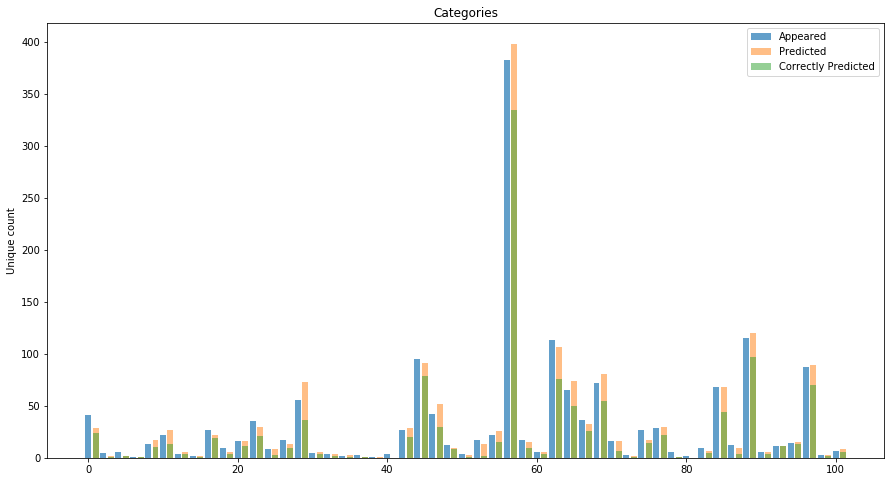

In [22]:
plt.figure(figsize=(15,8))
#plt.yscale('log')

plt.bar(yPosition, pod, alpha=0.7, label='Appeared')
plt.bar(yPosition, podp, alpha=0.5, label='Predicted')
plt.bar(yPosition, podc, alpha=0.5, label='Correctly Predicted')

plt.ylabel('Unique count')
plt.title('Categories')
plt.legend()
 
plt.show()

## Exploration of what went wrong

In [23]:
W2IX = {}
for k, v in tokenizer.word_index.items():
    W2IX[v] = k
def seq2sent(s, w2ix = W2IX):
    sent = []
    for w in s:
        if w != 0:
            sent.append(w2ix[w])
    return ' '.join(sent)

In [24]:
w_pred = {}
t_pred = {}
for c in np.arange(NB_CATEGORIES):
    w_pred[c] = []
    t_pred[c] = []

for q, t_lab, pred_lab in zip(xValid, yValidCategories, predictionCategories):
    q = seq2sent(q)
    if pred_lab == t_lab:
        t_pred[t_lab].append(tuple((pred_lab, q)))
    else:
        w_pred[t_lab].append(tuple((pred_lab, q)))

In [25]:
assignation_matrix = np.zeros((NB_CATEGORIES, NB_CATEGORIES))
for c in np.arange(NB_CATEGORIES):
    for e in w_pred[c]:
        assignation_matrix[c,e[0]] += 1

## Explore wrong predictions 

In [26]:
ix = 0
print('----------true predictions------------')
print(t_pred[ix][:10])
print('-----------wrong prediction------------')
w_pred[ix]

----------true predictions------------
[(0, 'quelle alternative à la rupture de havrix'), (0, 'quelle alternative au plavix'), (0, 'compose de depakote 100 mg je suis bipolaire de 3 xanax de 0 5 auparavent 4 j ai beaucoup de mal a diminuer et tercian neuroleptique que j aimerais arrêter donc me sevrer car il me shoote trop et c est pas compatible avec le travail de plus il me fait prendre bip de poids le tableau je suis insomniaque depuis 15 ans rien a faire alors je prends chaque soir un peu de mélatonine 5mg et ca m aide bcp est ce une bonne idée de remplacer le tercian qui m est donne pour dormir par de la melatonine'), (0, 'puis je prendre lectil à la place de serc ou bétaserc'), (0, 'le cérat de alien contre indiqué chez les enfants de moins de 3 ans quelle alternative'), (0, 'quelle alternative au méningite en cas de rupture'), (0, 'si cycline pour acné que faire pour remplacer pendant l été'), (0, 'est ce que le pneumovax est équivalent au pneumo 23'), (0, 'bonjour j aimerais ar

[(5, 'for et priopix la mémé chose ou pas'),
 (10, 'changement diane 35'),
 (42, '2 engerix 10 1 engerix 20'),
 (5,
  'je suis sous triella est ce que quelqu un s y connaîtrait dans le domaine et me conseillerai une pilule équivalente'),
 (38,
  'je prend du seresta 3 fois par jour mais je me réveille quand j arrive à dormir toujours en pleine crise d angoisse ne serait il pas plus judicieux de prendre un lexomil le soir qui a une durée de vie plus longue'),
 (12, 'allergique au flacon que faire'),
 (35,
  'comment traiter une dishydrose si le dermoval et une préparation sulfate de cuivre 10mg 10l d eau en bain et dermalibour n ont pas marché'),
 (47,
  'quelqu un connaît il l équivalent de la cérazette même condition mais remboursée svp'),
 (34,
  'j aurais aimer savoir si il n y as pas une pilule moins dosées et moins contraignante que jasminelle celle que je prends actuellement'),
 (9,
  'je voudrais savoir si vous connaissez un crémé qui est pareil ou presque au diprosept de celle 

## Category exploration

In [27]:
yCat = np.argmax(y, axis = 1)
sentence_list = selectCat(x, yCat, ix)[:]
sentence_list = [seq2sent(s) for s  in sentence_list]
print('{} questions in the category {}'.format(len(sentence_list), ix))
sentence_list[:10]

204 questions in the category 0


['comment traiter une dishydrose si le dermoval et une préparation sulfate de cuivre 10mg 10l d eau en bain et dermalibour n ont pas marché',
 'j ai des fortes brûlures d estomac je prends du rennie et ça ne me fait rien connaissez vous un remède plus efficace',
 'par quoi puis je remplacer engerix',
 'y a t il un médicament qui peu m aider a calmer l anxiété car le prozac ne calme pas vraiment',
 'je souffre de colopathie fonctionnelle et il s avère que la seule chose qui me fasse réellement du bien soit les anxiolytiques malheureusement je suis aussi atteint d une hépatite c et n ai donc pas droit à ce type de médicament y a t il une solution',
 'connaissez vous un équivalent au pansement opsine post opératoire',
 'quelle alternative à cialis',
 'bonjour je prends diane depuis 3 ans et elle est très bien pour moi mais je voudrais l arreter et en prendre une qui ne soit qu une contraception quelles sont les autres pilules qui ne sont pas néfastes pour la peu mais toutefois qui sont un